In [1]:
import pandas as pd
from datetime import datetime

In [2]:
df = pd.read_csv("sphist.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
sorted_df = df.sort_values(by=['Date'])

In [6]:
sorted_df = sorted_df.reset_index(drop=True)

Create time-windowed dataframe with some basic info about previous sales for each row

In [7]:
tw_df = sorted_df.copy()

We're going to use data for the previous 365 working days at max, meaning that we should start our training set one yearlater than the initial records

In [8]:
tw_df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
1,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
2,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
3,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
4,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


In [9]:
#tw_df.rolling(window=5)['Open'].mean().shift(1)

Target to predict - 'Close' column (the closing value of stock market). Because we are going to use simple linear regression instead of RNN (which is more appropriate as the dataset is a time-series in reality), we need to provide some basic statistics about the previous days for each row.

That includes the precise prices for last 3 days, mean, std, variance for last 7, 14, 30, 180, 365 days and some ratio between those values.

In [10]:
tw_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']].corr()['Close']

Open         0.999901
High         0.999954
Low          0.999956
Close        1.000000
Volume       0.774393
Adj Close    1.000000
Name: Close, dtype: float64

The mentioned statistics would be used for columns 'Close' and 'Volume'

In [11]:
stat_columns = ['Close', 'Volume']
new_stat_columns = []
for col in stat_columns:
    windows = [7, 14, 30, 180, 365]
    for window in windows:
        
        def get_col_name(func_name):
            name = col+'_'+func_name+'_'+str(window)
            new_stat_columns.append(name)
            return name
        
        tw_df[get_col_name('mean')] = tw_df.rolling(window=window)[col].mean().shift(1)
        tw_df[get_col_name('std')] = tw_df.rolling(window=window)[col].std().shift(1)
        tw_df[get_col_name('var')] = tw_df.rolling(window=window)[col].var().shift(1)

In [12]:
tw_df = tw_df.dropna(axis=0)

In [13]:
tw_df.head()

,Date,Open,High,Low,Close,Volume,Adj Close,Close_mean_7,Close_std_7,Close_var_7,...,Volume_var_14,Volume_mean_30,Volume_std_30,Volume_var_30,Volume_mean_180,Volume_std_180,Volume_var_180,Volume_mean_365,Volume_std_365,Volume_var_365
365,1951-06-19,22.020000,22.020000,22.020000,22.020000,1100000.0,22.020000,21.728571,0.244638,0.059848,...,5.322760e+12,1.707667e+06,1.566790e+06,2.454832e+12,2.075111e+06,907864.760490,8.242184e+11,1.989479e+06,772310.649463,5.964637e+11
366,1951-06-20,21.910000,21.910000,21.910000,21.910000,1120000.0,21.910000,21.804286,0.240476,0.057829,...,5.331825e+12,1.691667e+06,1.570585e+06,2.466739e+12,2.068111e+06,910509.580994,8.290277e+11,1.989041e+06,772771.102512,5.971752e+11
367,1951-06-21,21.780001,21.780001,21.780001,21.780001,1100000.0,21.780001,21.847143,0.226401,0.051257,...,5.341407e+12,1.675667e+06,1.573993e+06,2.477453e+12,2.062111e+06,913190.116407,8.339162e+11,1.986932e+06,774092.100761,5.992186e+11
368,1951-06-22,21.549999,21.549999,21.549999,21.549999,1340000.0,21.549999,21.884286,0.180449,0.032562,...,1.251429e+10,1.647000e+06,1.576465e+06,2.485242e+12,2.058222e+06,915799.345906,8.386884e+11,1.982959e+06,774914.749625,6.004929e+11
369,1951-06-25,21.290001,21.290001,21.290001,21.290001,2440000.0,21.290001,21.884286,0.180449,0.032562,...,1.414945e+10,1.636333e+06,1.577456e+06,2.488369e+12,2.053444e+06,917297.659921,8.414350e+11,1.981123e+06,775643.723180,6.016232e+11


In [17]:
corr_columns = new_stat_columns.copy()
corr_columns.append('Close')

In [18]:
tw_df[corr_columns].corr()['Close']

Close_mean_7       0.999743
Close_std_7        0.741346
Close_var_7        0.414952
Close_mean_14      0.999578
Close_std_14       0.764517
Close_var_14       0.444208
Close_mean_30      0.999189
Close_std_30       0.778583
Close_var_30       0.462857
Close_mean_180     0.995231
Close_std_180      0.772385
Close_var_180      0.451234
Close_mean_365     0.988870
Close_std_365      0.816103
Close_var_365      0.569187
Volume_mean_7      0.782221
Volume_std_7       0.633780
Volume_var_7       0.334966
Volume_mean_14     0.784848
Volume_std_14      0.663721
Volume_var_14      0.379888
Volume_mean_30     0.786908
Volume_std_30      0.684340
Volume_var_30      0.407893
Volume_mean_180    0.785872
Volume_std_180     0.696843
Volume_var_180     0.443765
Volume_mean_365    0.784878
Volume_std_365     0.684141
Volume_var_365     0.441265
Close              1.000000
Name: Close, dtype: float64

Every new column seems to have a rather strong correlation with the Close value (all above 0.3). Better keep them all for more reliable result.

In [19]:
features = new_stat_columns

In [21]:
train = tw_df[tw_df["Date"] < datetime(year=2013, month=1, day=1)]
test = tw_df[tw_df["Date"] >= datetime(year=2013, month=1, day=1)]

# Training the model

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

In [183]:
def compare_predictions(predicted, test, target_col):
    check_df = pd.DataFrame(data=predicted, index=test.index, columns=["Predicted"+target_col])
    check_df = pd.concat([check_df, test[[target_col, 'Close-1', 'Close-2', 'Close-3', 'Date']]], axis=1)
    #check_df[target_col] = test[target_col]
    check_df["Error, %"] = np.abs(check_df["Predicted"+target_col]*100/check_df[target_col] - 100)
    check_df['Error, val'] = check_df["Predicted"+target_col] - check_df[target_col]
    return (check_df.sort_index(), check_df["Error, %"].mean())

def test_model(train, test, features, target_col='Close'):    
    lr = LinearRegression()
    lr.fit(train[features], train[target_col])
    
    lr_train_pred = lr.predict(train[features])
    lr_train_rmse = mean_squared_error(lr_train_pred, train[target_col]) ** 0.5

    lr_test_pred = lr.predict(test[features])
    lr_test_rmse = mean_squared_error(lr_test_pred, test[target_col]) ** 0.5

    print("RMSE TRAIN AND TEST:")
    print(lr_train_rmse, lr_test_rmse)
    
    check_df, avg_error = compare_predictions(lr_test_pred, test, target_col)
    
    print("AVERAGE ERROR:", avg_error)
    
    print(check_df.head(10))
    
    return (lr, check_df)

In [172]:
lr, check_df = test_model(train, test, features, 'Close')

RMSE TRAIN AND TEST:
7.56298362557 15.0111667184
AVERAGE ERROR: 0.5775987771598083
       PredictedClose        Close  Error, %
15851     1425.961100  1462.420044  2.493056
15852     1460.259422  1459.369995  0.060946
15853     1459.250098  1466.469971  0.492330
15854     1466.290906  1461.890015  0.301041
15855     1461.693325  1457.150024  0.311794
15856     1457.247796  1461.020020  0.258191
15857     1459.126248  1472.119995  0.882655
15858     1469.707587  1472.050049  0.159129
15859     1470.545645  1470.680054  0.009139
15860     1469.729868  1472.339966  0.177275


In [30]:
check_df.head(25)

,PredictedClose,Close,"Error, %"
15851,1452.362944,1462.420044,0.687703
15852,1455.288112,1459.369995,0.279702
15853,1458.320010,1466.469971,0.555754
15854,1461.168099,1461.890015,0.049382
15855,1464.216205,1457.150024,0.484932
15856,1462.796492,1461.020020,0.121591
15857,1462.376558,1472.119995,0.661864
15858,1460.713718,1472.050049,0.770105
15859,1462.974936,1470.680054,0.523915
15860,1458.829998,1472.339966,0.917585


# 1.45 % average error. Not bad at all

Let's explore errors further

In [32]:
check_df.describe()

,PredictedClose,Close,"Error, %"
count,739.000000,739.000000,739.000000
mean,1875.416579,1874.890338,1.453202
std,203.373596,192.389058,1.258584
min,1452.362944,1457.150024,0.001002
25%,1687.616500,1697.450012,0.565138
50%,1931.645719,1920.239990,1.210973
75%,2048.249748,2052.165039,2.046506
max,2145.345516,2130.820068,12.922934


In [41]:
max_error = check_df[check_df['Error, %'] == check_df['Error, %'].max()]
print(max_error)

       PredictedClose        Close   Error, %
16517     2108.959984  1867.609985  12.922934


In [47]:
tw_df.loc[max_error.index].squeeze()

Date               2015-08-25 00:00:00
Open                           1898.08
High                           1948.04
Low                            1867.08
Close                          1867.61
Volume                     5.18356e+09
Adj Close                      1867.61
Close_mean_7                   2038.62
Close_std_7                    79.2595
Close_var_7                    6282.06
Close_mean_14                   2063.5
Close_std_14                   60.0823
Close_var_14                   3609.89
Close_mean_30                  2085.77
Close_std_30                   46.9882
Close_var_30                   2207.89
Close_mean_180                 2079.89
Close_std_180                  36.7927
Close_var_180                   1353.7
Close_mean_365                 2012.49
Close_std_365                   83.781
Close_var_365                  7019.25
Volume_mean_7              3.95423e+09
Volume_std_7               1.40989e+09
Volume_var_7                1.9878e+18
Volume_mean_14           

Sanity check: if the model would give the close value of the previous day, how big the average error would be?

In [60]:
sanity_check_df = pd.DataFrame(columns=['Predicted Close', 'Close', 'Error, %'])
sanity_check_df['Close'] = test['Close']
sanity_check_df['Predicted Close'] = test['Close'].shift(1)
sanity_check_df['Error, %'] = np.abs(sanity_check_df['Predicted Close']*100/sanity_check_df['Close'] - 100)
print(sanity_check_df['Error, %'].mean())

0.5850460333899026


In [61]:
sanity_check_df['Error, %'].describe()

count    738.000000
mean       0.585046
std        0.541897
min        0.000514
25%        0.190492
50%        0.440822
75%        0.816547
max        4.103087
Name: Error, %, dtype: float64

# Model failed to predict with better error than the sanity check model

Since the Close value seems to be very close to the Close values for the previous days, lets try to improve model by adding data for the past several days into each row. Also lets recheck correlation matrix and let there be a higher threshold.

In [77]:
tw2_df = tw_df.copy()

In [78]:
tw2_df['Close-1'] = tw2_df['Close'].shift(1)
tw2_df['Close-2'] = tw2_df['Close'].shift(2)
tw2_df['Close-3'] = tw2_df['Close'].shift(3)

In [79]:
tw2_df['Open-Close-1'] = (tw2_df['Open'] - tw2_df['Close']).shift(1)
tw2_df['Open-Close-2'] = (tw2_df['Open'] - tw2_df['Close']).shift(2)

In [81]:
correlations = tw2_df.corr()['Close']

In [101]:
correlations

Open               0.999900
High               0.999953
Low                0.999956
Close              1.000000
Volume             0.772817
Adj Close          1.000000
Close_mean_7       0.999743
Close_std_7        0.741346
Close_var_7        0.414952
Close_mean_14      0.999578
Close_std_14       0.764517
Close_var_14       0.444208
Close_mean_30      0.999189
Close_std_30       0.778583
Close_var_30       0.462857
Close_mean_180     0.995231
Close_std_180      0.772385
Close_var_180      0.451234
Close_mean_365     0.988870
Close_std_365      0.816103
Close_var_365      0.569187
Volume_mean_7      0.782221
Volume_std_7       0.633780
Volume_var_7       0.334966
Volume_mean_14     0.784848
Volume_std_14      0.663721
Volume_var_14      0.379888
Volume_mean_30     0.786908
Volume_std_30      0.684340
Volume_var_30      0.407893
Volume_mean_180    0.785872
Volume_std_180     0.696843
Volume_var_180     0.443765
Volume_mean_365    0.784878
Volume_std_365     0.684141
Volume_var_365     0

In [318]:
features = correlations[correlations.abs() > 0.6].index.tolist()

In [319]:
features.remove('Open')
features.remove('High')
features.remove('Low')
features.remove('Close')
features.remove('Adj Close')

In [320]:
features

['Volume',
 'Close_mean_7',
 'Close_std_7',
 'Close_mean_14',
 'Close_std_14',
 'Close_mean_30',
 'Close_std_30',
 'Close_mean_180',
 'Close_std_180',
 'Close_mean_365',
 'Close_std_365',
 'Volume_mean_7',
 'Volume_std_7',
 'Volume_mean_14',
 'Volume_std_14',
 'Volume_mean_30',
 'Volume_std_30',
 'Volume_mean_180',
 'Volume_std_180',
 'Volume_mean_365',
 'Volume_std_365',
 'Close-1',
 'Close-2',
 'Close-3']

In [222]:
tw2_df = tw2_df.dropna(axis=0)

In [223]:
train = tw2_df[tw2_df["Date"] < datetime(year=2013, month=1, day=1)]
test = tw2_df[tw2_df["Date"] >= datetime(year=2013, month=1, day=1)]

In [224]:
lr, check_df = test_model(train, test, features, 'Close')

RMSE TRAIN AND TEST:
7.5650945549 14.9950316861
AVERAGE ERROR: 0.577996881035828
       PredictedClose        Close      Close-1      Close-2      Close-3  \
15851     1425.647886  1462.420044  1426.189941  1402.430054  1418.099976   
15852     1459.944635  1459.369995  1462.420044  1426.189941  1402.430054   
15853     1458.924864  1466.469971  1459.369995  1462.420044  1426.189941   
15854     1465.956896  1461.890015  1466.469971  1459.369995  1462.420044   
15855     1461.356034  1457.150024  1461.890015  1466.469971  1459.369995   
15856     1456.934537  1461.020020  1457.150024  1461.890015  1466.469971   
15857     1458.836258  1472.119995  1461.020020  1457.150024  1461.890015   
15858     1469.433237  1472.050049  1472.119995  1461.020020  1457.150024   
15859     1470.264041  1470.680054  1472.050049  1472.119995  1461.020020   
15860     1469.444196  1472.339966  1470.680054  1472.050049  1472.119995   

            Date  Error, %  Error, val  
15851 2013-01-02  2.514473  -3

In [225]:
check_df['Error, %'].describe()

count    739.000000
mean       0.577997
std        0.544528
min        0.000659
25%        0.174984
50%        0.431790
75%        0.808005
max        4.441783
Name: Error, %, dtype: float64

# 0.578 % Error. Much better, beat the simpleton model error (0.585%).

Got to explore errors further, especially in context of the previous values used

In [226]:
check_df.head(10)

,PredictedClose,Close,Close-1,Close-2,Close-3,Date,"Error, %","Error, val"
15851,1425.647886,1462.420044,1426.189941,1402.430054,1418.099976,2013-01-02,2.514473,-36.772158
15852,1459.944635,1459.369995,1462.420044,1426.189941,1402.430054,2013-01-03,0.039376,0.574640
15853,1458.924864,1466.469971,1459.369995,1462.420044,1426.189941,2013-01-04,0.514508,-7.545107
15854,1465.956896,1461.890015,1466.469971,1459.369995,1462.420044,2013-01-07,0.278193,4.066881
15855,1461.356034,1457.150024,1461.890015,1466.469971,1459.369995,2013-01-08,0.288646,4.206010
15856,1456.934537,1461.020020,1457.150024,1461.890015,1466.469971,2013-01-09,0.279632,-4.085483
15857,1458.836258,1472.119995,1461.020020,1457.150024,1461.890015,2013-01-10,0.902354,-13.283737
15858,1469.433237,1472.050049,1472.119995,1461.020020,1457.150024,2013-01-11,0.177767,-2.616812
15859,1470.264041,1470.680054,1472.050049,1472.119995,1461.020020,2013-01-14,0.028287,-0.416013
15860,1469.444196,1472.339966,1470.680054,1472.050049,1472.119995,2013-01-15,0.196678,-2.895770


In [227]:
check_df.tail(10)

,PredictedClose,Close,Close-1,Close-2,Close-3,Date,"Error, %","Error, val"
16580,2088.849327,2086.590088,2089.169922,2081.239990,2083.580078,2015-11-23,0.108274,2.259239
16581,2086.359226,2089.139893,2086.590088,2089.169922,2081.239990,2015-11-24,0.133101,-2.780667
16582,2089.666591,2088.870117,2089.139893,2086.590088,2089.169922,2015-11-25,0.038129,0.796474
16583,2090.888971,2090.110107,2088.870117,2089.139893,2086.590088,2015-11-27,0.037264,0.778864
16584,2087.900723,2080.409912,2090.110107,2088.870117,2089.139893,2015-11-30,0.360064,7.490811
16585,2079.673737,2102.629883,2080.409912,2090.110107,2088.870117,2015-12-01,1.091783,-22.956146
16586,2099.867933,2079.510010,2102.629883,2080.409912,2090.110107,2015-12-02,0.978977,20.357923
16587,2078.431966,2049.620117,2079.510010,2102.629883,2080.409912,2015-12-03,1.405717,28.811849
16588,2051.474556,2091.689941,2049.620117,2079.510010,2102.629883,2015-12-04,1.922626,-40.215385
16589,2089.399647,2077.070068,2091.689941,2049.620117,2079.510010,2015-12-07,0.593604,12.329579


In [228]:
check_df['Error, val'].describe()

count    739.000000
mean      -0.117993
std       15.004723
min      -60.536161
25%       -8.384511
50%       -0.846253
75%        7.373025
max       84.092277
Name: Error, val, dtype: float64

In [229]:
import matplotlib.pyplot as plt

%matplotlib inline

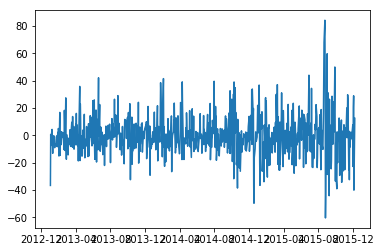

In [230]:
plt.plot(check_df['Date'], check_df['Error, val'])
plt.show()

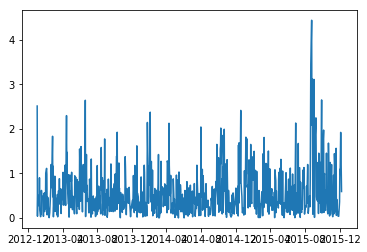

In [233]:
plt.plot(check_df['Date'], check_df['Error, %'])
plt.show()

Let's explore the biggest errors in test set

In [236]:
check_df = check_df.sort_values(by=['Error, %'], ascending=False)

In [289]:
top_errors = check_df.iloc[:20]

In [290]:
top_errors

,PredictedClose,Close,Close-1,Close-2,Close-3,Date,"Error, %","Error, val"
16516,1977.302238,1893.209961,1970.890015,2035.729980,2079.610107,2015-08-24,4.441783,84.092277
16515,2038.798370,1970.890015,2035.729980,2079.610107,2096.919922,2015-08-21,3.445568,67.908355
16518,1879.973849,1940.510010,1867.609985,1893.209961,1970.890015,2015-08-26,3.119601,-60.536161
16522,1973.430723,1913.849976,1972.180054,1988.869995,1987.660034,2015-09-01,3.113136,59.580747
16540,1931.659780,1881.770020,1931.339966,1932.239990,1938.760010,2015-09-28,2.651215,49.889760
15968,1630.186837,1588.189941,1628.930054,1651.810059,1639.040039,2013-06-20,2.644325,41.996896
15851,1425.647886,1462.420044,1426.189941,1402.430054,1418.099976,2013-01-02,2.514473,-36.772158
16346,2011.418048,2061.229980,2012.890015,1972.739990,1989.630005,2014-12-18,2.416612,-49.811932
16124,1783.281703,1741.890015,1782.589966,1794.189941,1774.199951,2014-02-03,2.376252,41.391688
15921,1588.052334,1552.359985,1588.849976,1593.369995,1587.729980,2013-04-15,2.299231,35.692349


In [314]:
def plot_errors(dataframe, fixed_y=True):
    fig = plt.figure(figsize=(16, 20))
    plt.subplots_adjust(top=2)
    c = 1
    for row in dataframe.iterrows():

        previous_vals = []
        for i in range(1, 10):
            data = sorted_df.loc[row[0]-i]
            previous_vals.append(data['Close'])
        previous_vals.reverse()
        actual_value = sorted_df.loc[row[0]]['Close']
        predicted_value = row[1]['PredictedClose']

        ax = fig.add_subplot(10, 4, c)
        if fixed_y:
            ax.set_ylim(1400,2200)
        ax.plot([x for x in range(0, 9)], previous_vals, c='grey', linewidth=3)
        ax.scatter([9], [predicted_value], c='r')
        ax.scatter([9], [actual_value], c='blue')
        ax.set_title('Error, %: ' + str(row[1]['Error, %']))

        c+=1

    plt.show()

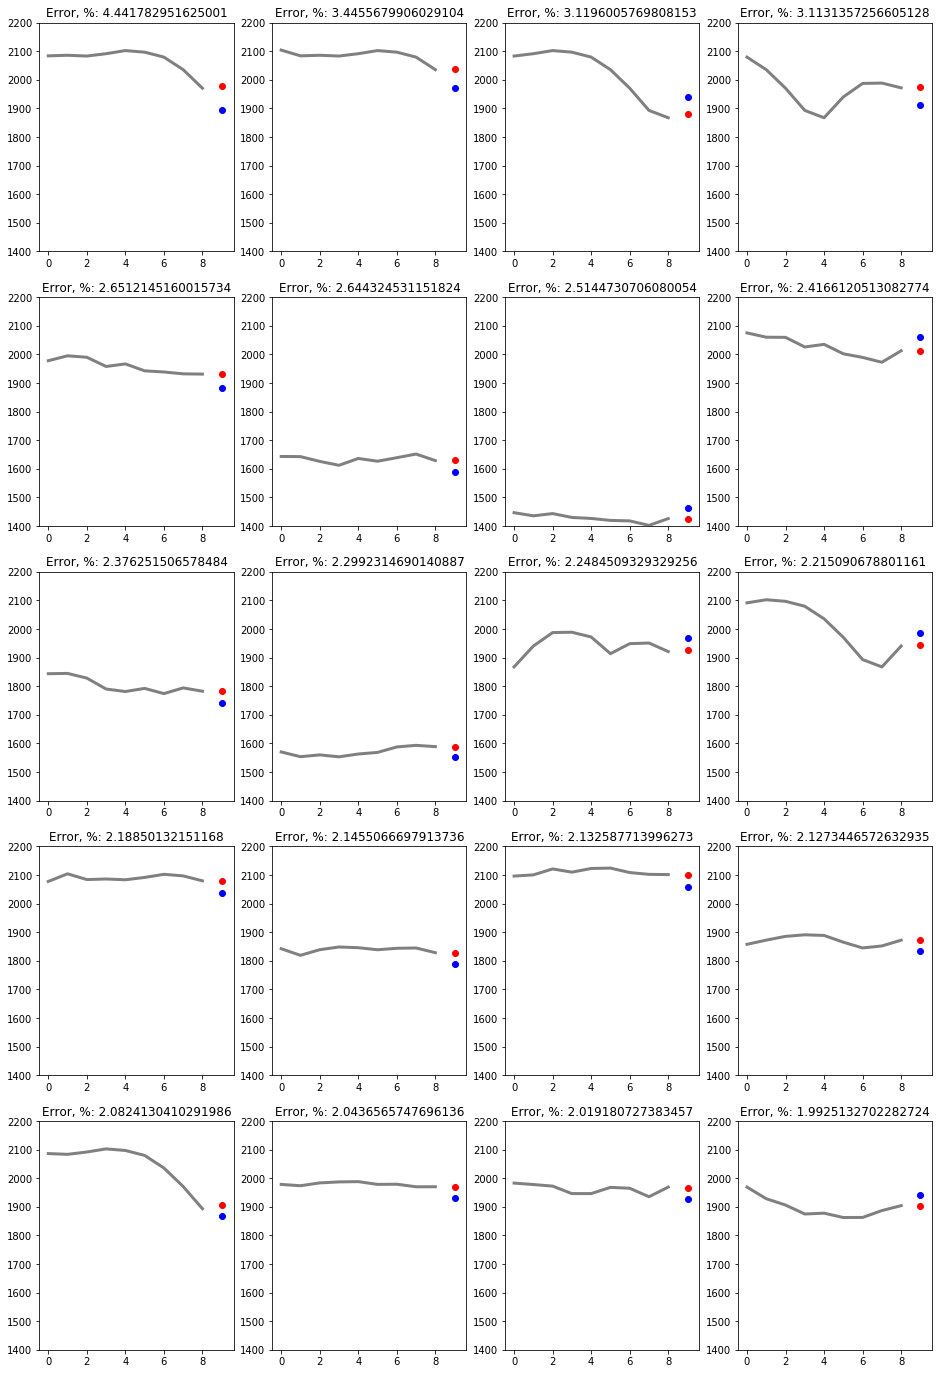

In [310]:
plot_errors(top_errors)

On the presented plots it is seen that model predicts values very close to the previous one, completely disregarding the slope of the curve. Further analisys required in order to understand, whether this was generally harmful or helpful and whether this requires fixing or not.

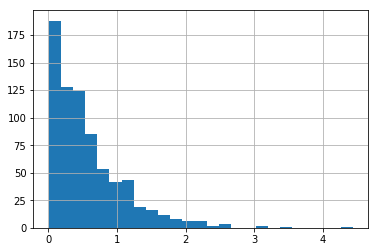

In [308]:
check_df['Error, %'].hist(bins=25)

Judging by histogram, the best course of action would be to try to fix errors from 0.2 to 1.5%

In [312]:
def get_sample_errors(dataset, e_min, e_max):
    filtered_df = dataset[(dataset['Error, %'] > e_min) & (dataset['Error, %'] < e_max)]
    return filtered_df.sample(frac=1)[:20]

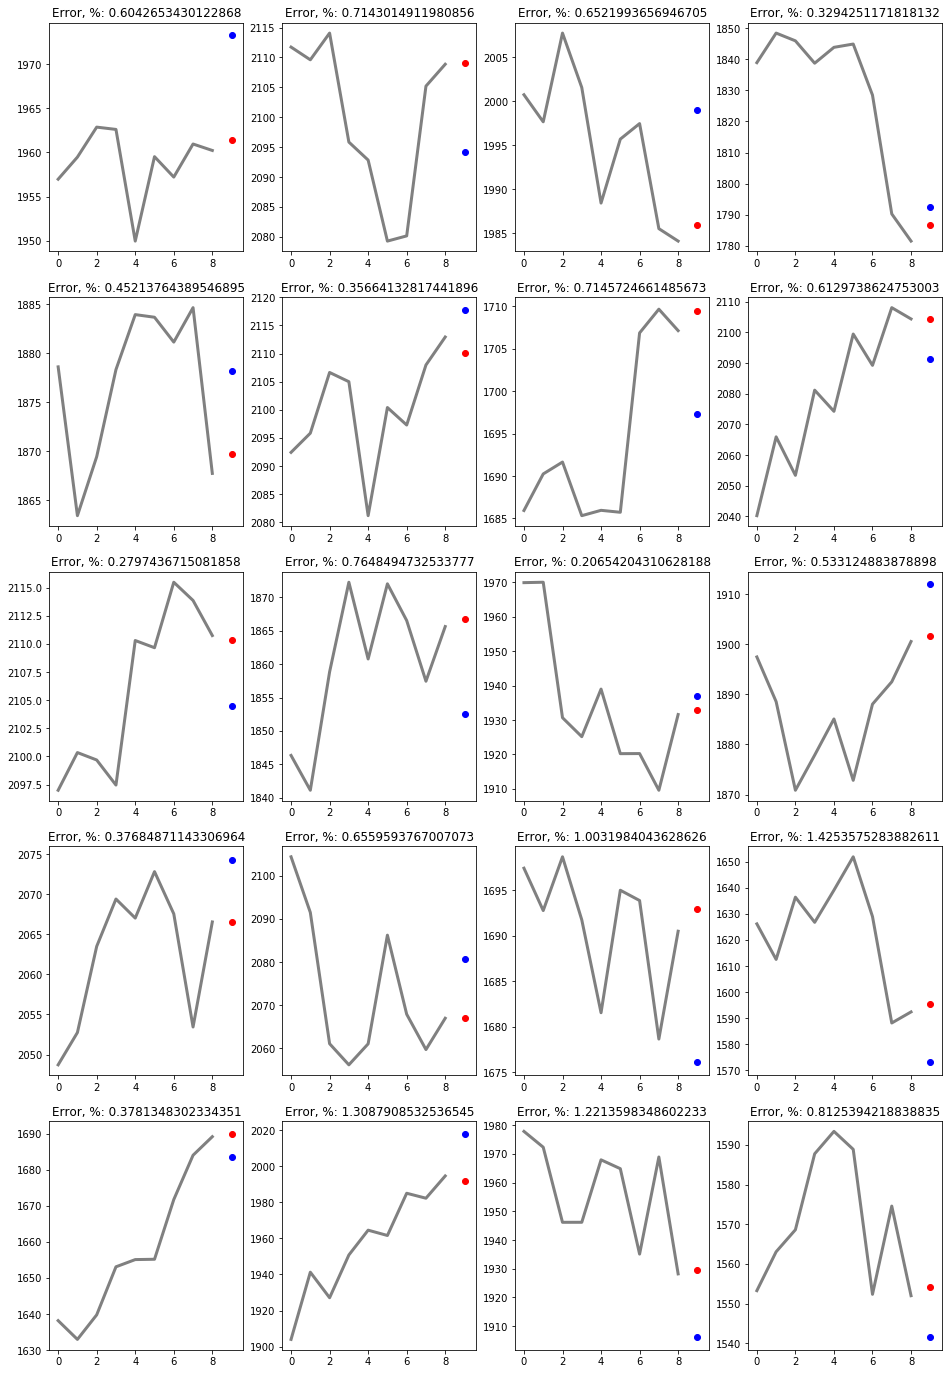

In [315]:
plot_errors(get_sample_errors(check_df, 0.2, 1.5), False)

The errors we see on the plots can be fixed when the appropriate non-linear algorithm is applied. In order to solve it in the most efficient way with Linear regression, I think we should use larger time window (~10 or so days instead of 2) and the more frequently refreshed statistical info (std for the last 3, 6, 9 etc days).

In [337]:
tw3_df = tw2_df.copy()
features3 = features.copy()

In [338]:
features_tw3 = []
for i in range(1, 30):          #using time-window of 30
    cols = ['Close', 'Open']    #add 'Open' because it could indicate whether the stocks go up or down
    for col in cols:
        def get_feature_name(column, index):
            name = column + '-' + str(index)
            features_tw3.append(name)
            return name
        
        tw3_df[get_feature_name(col, i)] = tw3_df[col].shift(i)

In [339]:
windows = [3, 7, 14, 21, 28, 60, 90, 180]
for window in windows:
    def get_col_name(func_name):
        name = 'Close'+'_'+func_name+'_'+str(window)
        features_tw3.append(name)
        return name

    tw3_df[get_col_name('mean')] = tw3_df.rolling(window=window)['Close'].mean().shift(1)
    tw3_df[get_col_name('std')] = tw3_df.rolling(window=window)['Close'].std().shift(1)
    tw3_df[get_col_name('var')] = tw3_df.rolling(window=window)['Close'].var().shift(1)

In [340]:
tw3_df = tw3_df.dropna(axis=0)

In [346]:
correlations3 = tw3_df.corr()['Close'].sort_values(ascending=False)

In [372]:
strong_correlations3 = correlations3[correlations3.abs() > 0.7].index.tolist()

In [373]:
strong_correlations3.remove('Open')
strong_correlations3.remove('High')
strong_correlations3.remove('Low')
strong_correlations3.remove('Close')
strong_correlations3.remove('Adj Close')

In [374]:
print(len(strong_correlations3))
print(strong_correlations3)

83
['Close-1', 'Close_mean_3', 'Open-1', 'Close-2', 'Close_mean_7', 'Open-2', 'Close-3', 'Open-3', 'Close-4', 'Close_mean_14', 'Open-4', 'Close-5', 'Open-5', 'Close-6', 'Close_mean_21', 'Open-6', 'Close-7', 'Open-7', 'Close-8', 'Open-8', 'Close-9', 'Close_mean_28', 'Open-9', 'Close-10', 'Close_mean_30', 'Open-10', 'Close-11', 'Open-11', 'Close-12', 'Open-12', 'Close-13', 'Open-13', 'Close-14', 'Open-14', 'Close-15', 'Open-15', 'Close-16', 'Open-16', 'Close-17', 'Open-17', 'Close-18', 'Open-18', 'Close-19', 'Close_mean_60', 'Open-19', 'Close-20', 'Open-20', 'Close-21', 'Open-21', 'Close-22', 'Open-22', 'Close-23', 'Open-23', 'Close-24', 'Open-24', 'Close-25', 'Open-25', 'Close-26', 'Open-26', 'Close-27', 'Open-27', 'Close-28', 'Open-28', 'Close_mean_90', 'Close-29', 'Open-29', 'Close_mean_180', 'Close_mean_365', 'Close_std_365', 'Volume_mean_30', 'Volume_mean_180', 'Volume_mean_365', 'Volume_mean_14', 'Volume_mean_7', 'Close_std_30', 'Close_std_28', 'Close_std_60', 'Close_std_90', 'Volu

Having that many learning features on a simple linear regression might have a rather harmful effect. Let's test the model

In [375]:
train = tw3_df[tw3_df["Date"] < datetime(year=2013, month=1, day=1)]
test = tw3_df[tw3_df["Date"] >= datetime(year=2013, month=1, day=1)]

In [376]:
lr, check_df = test_model(train, test, strong_correlations3, 'Close')

RMSE TRAIN AND TEST:
7.50652311414 15.3969799666
AVERAGE ERROR: 0.6088488036078049
       PredictedClose        Close      Close-1      Close-2      Close-3  \
15851     1425.074988  1462.420044  1426.189941  1402.430054  1418.099976   
15852     1462.179922  1459.369995  1462.420044  1426.189941  1402.430054   
15853     1459.316114  1466.469971  1459.369995  1462.420044  1426.189941   
15854     1468.320395  1461.890015  1466.469971  1459.369995  1462.420044   
15855     1460.971662  1457.150024  1461.890015  1466.469971  1459.369995   
15856     1456.269545  1461.020020  1457.150024  1461.890015  1466.469971   
15857     1458.256645  1472.119995  1461.020020  1457.150024  1461.890015   
15858     1469.437333  1472.050049  1472.119995  1461.020020  1457.150024   
15859     1470.048144  1470.680054  1472.050049  1472.119995  1461.020020   
15860     1469.679806  1472.339966  1470.680054  1472.050049  1472.119995   

            Date  Error, %  Error, val  
15851 2013-01-02  2.553648  

In [377]:
check_df['Error, %'].describe()

count    739.000000
mean       0.608849
std        0.543017
min        0.000238
25%        0.216098
50%        0.481882
75%        0.834098
max        4.547330
Name: Error, %, dtype: float64

# Conclusion

All used approaches didn't improved model too much. Error (0.577%) is better (though very close) than the simpleton model's error (which just returns the 'Close' value from the previous day) (0.585%). Further improvements require usage of more advanced algorithms.